In [1]:
%pylab inline
import cosima_cookbook as cc
import numpy as np
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import scipy as sp
import pandas as pd
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import netCDF4 as nc
import matplotlib.gridspec as gridspec
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import pylab
from matplotlib import ticker, cm
# for georefferenced data
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm # for colormap
from sklearn import preprocessing

import dask
#dask.config.set({'temporary_directory': '/g/data/e14/ss2778/data'})



Populating the interactive namespace from numpy and matplotlib


In [2]:
#Creating my own database:
db = '/g/data/e14/ss2778/cc_test1.db'
session = cc.database.create_session(db)

In [3]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [17]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36289 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.67 GB


In [4]:
dir_list=['/g/data/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091']
cc.database.build_index(dir_list,session,update=True)

Indexing experiment: 01deg_jra55v13_ryf9091


100%|██████████| 112/112 [00:16<00:00,  6.65it/s]


112

In [4]:
#Extracting data from the path:
#df = (xr.open_mfdataset('/g/data/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091/output*/ocean/ocean_scalar*.nc'))
#df1 = (xr.open_mfdataset('/g/data/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091/output*/ocean/ocean_month*.nc'))

In [5]:
%time
expt =  '01deg_jra55v13_ryf9091'
var1 = 'mld'
MLD = cc.querying.getvar(expt, var1, session)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/cosima_cookbook/querying.py:96: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  preprocess=lambda d: d[variable].to_dataset() if variable not in d.coords else d)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option t

NameError: name 'os' is not defined

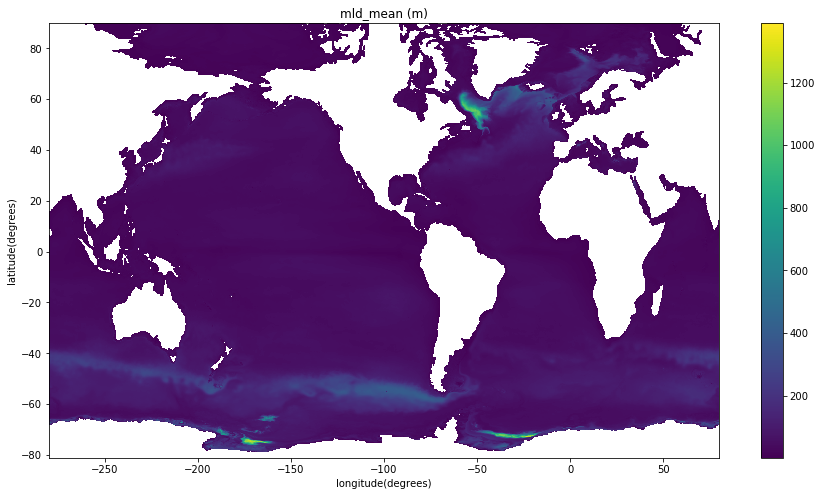

In [8]:
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(MLD.xt_ocean,MLD.yt_ocean)
mldm=MLD.mean('time')
h=plt.pcolormesh(X,Y,mldm)
cb = plt.colorbar(h,orientation='vertical')
#plt.contour(X,Y,levels=20, linewidths=0.5, colors='k')
plt.title('mld_mean (m)')
plt.ylabel('latitude(degrees)')
plt.xlabel('longitude(degrees)')
savefigure('mld_mean_50year')

In [9]:
mld_10=MLD.isel(time=slice(0,120));
mld_10

<xarray.DataArray 'mld' (time: 120, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<getitem, shape=(120, 2700, 3600), dtype=float32, chunksize=(1, 675, 900), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) object 1900-01-16 12:00:00 ... 1909-12-16 12:00:00
Attributes:
    long_name:      mixed layer depth determined by density criteria
    units:          m
    valid_range:    [      0. 1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t

In [11]:
#MLD trend over 30 years
mld_time = mld_10.time.values.astype('datetime64[M]').astype('float64')
etime = (mld_time-mld_time.mean())/mld_time.std()
mld=mld_10-mld_10.mean('time')
tl=len(mld.time)

In [ ]:
%time
trend_mld= np.dot(etime,np.transpose(mld.values,(1,0,2)))/tl

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21.7 µs


In [32]:
360* 3600 * 2700 / 1024.0**3

3.2588839530944824

In [12]:
#Seasonal Mld plots:
mld_season_mean = MLD.groupby('time.season').mean('time')
mld_season = MLD.groupby('time.season')
mld_season_anom = mld_season - mld_season_mean

In [13]:
mld_s1=mld_season_mean[0,:,:]
mld_s2=mld_season_mean[1,:,:]
mld_s3=mld_season_mean[2,:,:]
mld_s4=mld_season_mean[3,:,:]

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


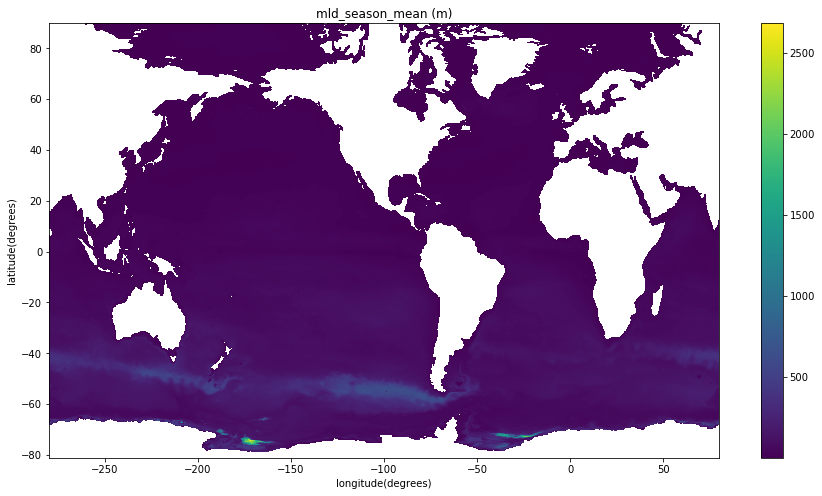

In [11]:
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(MLD.xt_ocean,MLD.yt_ocean)
mld_s1=mld_season_mean[1,:,:]
h=plt.pcolormesh(X,Y,mld_s1)
cb = plt.colorbar(h,orientation='vertical')
#plt.contour(X,Y,levels=20, linewidths=0.5, colors='k')
plt.title('mld_season_mean (m)')
plt.ylabel('latitude(degrees)')
plt.xlabel('longitude(degrees)')
savefigure('mld_season_plots')